In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import contextily as ctx
from geopy.distance import geodesic
from esda.moran import Moran
from libpysal.weights import Queen
from splot.esda import moran_scatterplot, plot_moran
import contextily as ctx
import matplotlib.ticker as mticker
from matplotlib.colors import Normalize


from statsmodels.tsa.stattools import grangercausalitytests

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from shapely.geometry import Point
from pysal.model import spreg
from linearmodels.panel import PanelOLS
from libpysal.weights import KNN, lag_spatial

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from shapely.geometry import Point
import warnings

/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

In [2]:
warnings.filterwarnings("ignore")

In [3]:
from libpysal.weights import W, full2W
import seaborn as sns
from scipy import stats

# 1.Data Processing

In [4]:
data = pd.read_csv('data.csv')
# Replace '..' with NaN
data.replace('..', np.nan, inplace=True)

# Drop rows with any NaN values
data.dropna(inplace=True)

# Display the first few rows of the cleaned data
data.head(30)

,country,ISO3,year,broadband,telephone,cellular,internet,credit,education,ict,...,gdppc,urban,articles,business,fdi_outflow,fdi_inflow,gdp,gdp_growth,latitude,longitude
0,Austria,AUT,2009,1878524,3253000,11434000,73.45,97.73957467,67.99157715,4.012334698,...,42655.192130,57.683,10837.18,1.098368169,3.872516754,3.559366135,3.560000e+11,-3.764578,48.210033,16.363449
1,Austria,AUT,2010,2050400,3398000,12241000,75.17,98.52832394,75.04025269,3.94819967,...,43334.508960,57.399,11058.41,1.068585825,-3.652443041,-5.610176315,3.620000e+11,1.837094,48.210033,16.363449
2,Austria,AUT,2011,2097700,3388000,13022578,78.7399931,96.06109929,77.26251221,3.7939034,...,44451.000190,57.115,11683.33,0.961632824,8.836365763,5.324236737,3.730000e+11,2.922797,48.210033,16.363449
3,Austria,AUT,2012,2130200,3380000,13588000,80.02999392,94.22379903,79.54712677,3.889467798,...,44549.881700,57.147,12050.36,0.99565769,4.505182228,1.274693933,3.760000e+11,0.680446,48.210033,16.363449
4,Austria,AUT,2013,2232500,3334000,13272000,80.6188,92.55775212,80.96160126,4.206127886,...,44299.378180,57.336,12201.98,1.046682823,2.56421002,0.104862186,3.760000e+11,0.025505,48.210033,16.363449
5,Austria,AUT,2014,2359000,3518900,12952605,80.99582496,87.55558785,81.0195694,4.277068444,...,44245.168740,57.526,12408.16,1.232728677,-0.197784974,0.386858115,3.780000e+11,0.661273,48.210033,16.363449
6,Austria,AUT,2015,2455500,3609900,13470623,83.94014193,85.89120788,82.25630951,4.116075846,...,44195.817590,57.715,12840.55,1.084121534,-0.560119576,-2.088056539,3.820000e+11,1.014502,48.210033,16.363449
7,Austria,AUT,2016,2523300,3567200,11079460,84.32374257,83.13573566,82.8496933,3.791092514,...,44590.251630,57.905,12668.55,1.012047577,-6.799712539,-7.310916958,3.900000e+11,1.989437,48.210033,16.363449
8,Austria,AUT,2017,2511400,3711200,10859000,87.93558659,84.26289373,83.83925629,3.483219307,...,45281.723400,58.094,12756.54,1.024764549,2.422529343,3.23990498,3.980000e+11,2.258572,48.210033,16.363449
9,Austria,AUT,2018,2521200,3735346,10984000,87.47913723,84.41367028,85.86988831,3.4121475,...,46154.625100,58.297,12713.75,0.994755862,-5.915302474,-6.287101585,4.080000e+11,2.425385,48.210033,16.363449


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290 entries, 0 to 426
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              290 non-null    object 
 1   ISO3                 290 non-null    object 
 2   year                 290 non-null    int64  
 3   broadband            290 non-null    object 
 4   telephone            290 non-null    object 
 5   cellular             290 non-null    object 
 6   internet             290 non-null    object 
 7   credit               290 non-null    object 
 8   education            290 non-null    object 
 9   ict                  290 non-null    object 
 10  tech                 290 non-null    object 
 11  patent_residents     290 non-null    object 
 12  patent_nonresidents  290 non-null    object 
 13  researchers          290 non-null    object 
 14  RD                   290 non-null    object 
 15  gdppc                290 non-null    float64


In [6]:

# Check the columns and data types
print("Data types before conversion:\n", data.dtypes)

# Convert object type columns to numeric (if possible)
for col in data.select_dtypes(include=['object']).columns:
    if col not in ['country', 'ISO3']:
        try:
            data[col] = pd.to_numeric(data[col])
        except ValueError:
            print(f"Column {col} could not be converted to numeric and will be dropped.")
            data = data.drop(columns=[col])

# Drop columns that are still of object type (if necessary)
#data = data.select_dtypes(exclude=['object'])

# Check the columns and data types after conversion
print("Data types after conversion:\n", data.dtypes)

Data types before conversion:
 country                 object
ISO3                    object
year                     int64
broadband               object
telephone               object
cellular                object
internet                object
credit                  object
education               object
ict                     object
tech                    object
patent_residents        object
patent_nonresidents     object
researchers             object
RD                      object
gdppc                  float64
urban                  float64
articles                object
business                object
fdi_outflow             object
fdi_inflow              object
gdp                    float64
gdp_growth             float64
latitude               float64
longitude              float64
dtype: object
Data types after conversion:
 country                 object
ISO3                    object
year                     int64
broadband                int64
telephone                i

In [7]:
data['patent'] = data['patent_residents'] + data['patent_nonresidents']

print(data)

         country ISO3  year  broadband  telephone    cellular   internet  \
0        Austria  AUT  2009    1878524    3253000  11434000.0  73.450000   
1        Austria  AUT  2010    2050400    3398000  12241000.0  75.170000   
2        Austria  AUT  2011    2097700    3388000  13022578.0  78.739993   
3        Austria  AUT  2012    2130200    3380000  13588000.0  80.029994   
4        Austria  AUT  2013    2232500    3334000  13272000.0  80.618800   
..           ...  ...   ...        ...        ...         ...        ...   
414       Sweden  SWE  2018    3942088    2163913  12626282.0  89.246963   
415       Sweden  SWE  2019    4038725    1750989  12895854.0  94.493443   
416       Sweden  SWE  2020    4179574    1478610  12791840.0  94.539431   
423  Switzerland  CHE  2012    3212371    4721981  10561075.0  85.200000   
426  Switzerland  CHE  2015    3700563    4140000  11243210.0  87.479056   

         credit  education       ict  ...   urban  articles  business  \
0     97.73957

# 2.Digital Economy Level

In [8]:
# Columns to be scaled
columns_to_scale = ['broadband', 'telephone', 'internet', 'cellular', 'credit', 'ict', 'tech']

In [9]:
#Standardize the data

scaler = MinMaxScaler()

data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])

In [10]:
# Calculate entropy
def calculate_entropy(data):
    P = data / data.sum(axis=0)  # Calculate the probability distribution
    E = -np.nansum(P * np.log(P), axis=0) / np.log(len(data))  # entropy
    return E

# Calculate weights
def calculate_weights(entropy):
    d = 1 - entropy  # Calculate the degree of diversification
    w = d / d.sum()  # Calculate weights
    return w

# Calculate the entropy for each indicator
entropy = calculate_entropy(data[columns_to_scale])

# Calculate the weights for each indicator
weights = calculate_weights(entropy)


print("Entropy:\n", entropy)
print("Weights:\n", weights)

Entropy:
 [0.86355881 0.82529823 0.99006689 0.87926367 0.95896188 0.92231142
 0.95240911]
Weights:
 [0.22436188 0.28727702 0.01633386 0.19853705 0.06748248 0.12774995
 0.07825776]


In [11]:
# Compute the comprehensive DE score
data['DE_index'] = data[columns_to_scale].dot(weights)

print(data.head())

   country ISO3  year  broadband  telephone  cellular  internet    credit  \
0  Austria  AUT  2009   0.048886   0.062718  0.100770  0.595704  0.317835   
1  Austria  AUT  2010   0.053647   0.065709  0.108155  0.623508  0.321264   
2  Austria  AUT  2011   0.054957   0.065502  0.115307  0.681220  0.310539   
3  Austria  AUT  2012   0.055857   0.065338  0.120481  0.702073  0.302552   
4  Austria  AUT  2013   0.058691   0.064389  0.117589  0.711592  0.295310   

   education       ict  ...  articles  business  fdi_outflow  fdi_inflow  \
0  67.991577  0.077526  ...  10837.18  1.098368     3.872517    3.559366   
1  75.040253  0.075981  ...  11058.41  1.068586    -3.652443   -5.610176   
2  77.262512  0.072265  ...  11683.33  0.961633     8.836366    5.324237   
3  79.547127  0.074567  ...  12050.36  0.995658     4.505182    1.274694   
4  80.961601  0.082194  ...  12201.98  1.046683     2.564210    0.104862   

            gdp  gdp_growth   latitude  longitude  patent  DE_index  
0  3.56000

In [12]:
# Save the results to a CSV file
#data.to_csv('DE_Level.csv', index=False)

# 3.Innovation Level

In [13]:
# Columns to be scaled
columns_innovation = ['patent', 'articles', 'business']

In [14]:
#Standardize the data

scaler = MinMaxScaler()

data[columns_innovation] = scaler.fit_transform(data[columns_innovation])

In [15]:
# Calculate the entropy for each indicator
entropy_inov = calculate_entropy(data[columns_innovation])

# Calculate the weights for each indicator
weights_innovation = calculate_weights(entropy_inov)


print("Entropy:\n", entropy_inov)
print("Weights:\n", weights_innovation)

Entropy:
 [0.73753936 0.88441197 0.94534482]
Weights:
 [0.60655952 0.26712967 0.12631082]


In [16]:
# Compute the comprehensive DE score
data['Innovation_index'] = data[columns_innovation].dot(weights_innovation)

print(data.head())

   country ISO3  year  broadband  telephone  cellular  internet    credit  \
0  Austria  AUT  2009   0.048886   0.062718  0.100770  0.595704  0.317835   
1  Austria  AUT  2010   0.053647   0.065709  0.108155  0.623508  0.321264   
2  Austria  AUT  2011   0.054957   0.065502  0.115307  0.681220  0.310539   
3  Austria  AUT  2012   0.055857   0.065338  0.120481  0.702073  0.302552   
4  Austria  AUT  2013   0.058691   0.064389  0.117589  0.711592  0.295310   

   education       ict  ...  business  fdi_outflow  fdi_inflow           gdp  \
0  67.991577  0.077526  ...  0.032310     3.872517    3.559366  3.560000e+11   
1  75.040253  0.075981  ...  0.031091    -3.652443   -5.610176  3.620000e+11   
2  77.262512  0.072265  ...  0.026713     8.836366    5.324237  3.730000e+11   
3  79.547127  0.074567  ...  0.028106     4.505182    1.274694  3.760000e+11   
4  80.961601  0.082194  ...  0.030194     2.564210    0.104862  3.760000e+11   

   gdp_growth   latitude  longitude    patent  DE_index 

# 4.Geographically Weighted Regression

In [17]:
print(data.columns)

Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular',
       'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents',
       'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban',
       'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp',
       'gdp_growth', 'latitude', 'longitude', 'patent', 'DE_index',
       'Innovation_index'],
      dtype='object')


In [18]:
# Dynamically patch numpy deprecations in spglm
import spglm
import sys

if 'spglm.iwls' in sys.modules:
    del sys.modules['spglm.iwls']
    
import spglm.iwls

spglm.iwls.np.float = np.float64

In [19]:
# Ensure all required columns are present
required_columns = ['ISO3', 'latitude', 'longitude', 'DE_index', 'Innovation_index', 'education', 'researchers', 'RD', 'gdppc', 'urban', 'fdi_inflow']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"{missing_columns} not in index")

Text(0.5, 1.0, 'Correlation Matrix')

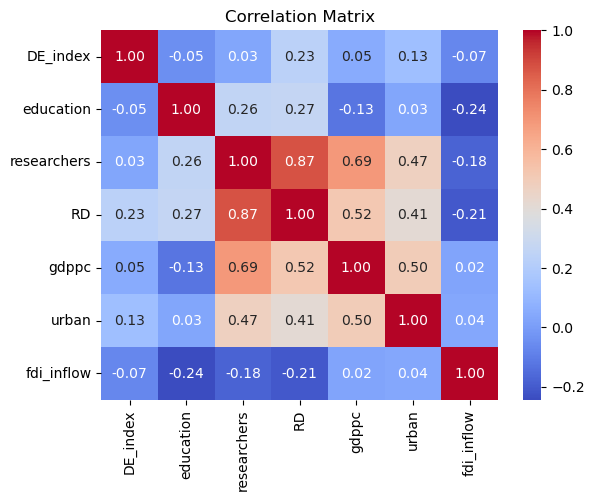

In [20]:
# Select only the columns of interest for the correlation matrix
cols_of_interest = ['DE_index', 'education', 'researchers', 'RD', 'gdppc', 'urban', 'fdi_inflow']
sci_selected = data[cols_of_interest]


sns.heatmap(sci_selected.corr(numeric_only=True), # plot a correlation matrix 
            annot=True, # show the correlation values on the plot
            fmt=".2f", # set the format of the correlation values to be two decimal places
            cmap='coolwarm') # set the color palette to be coolwarm (blue for negative correlations, red for positive correlations)

plt.title('Correlation Matrix') # add a title

In [21]:
# Create GeoDataFrame
gdf = gpd.GeoDataFrame(data.copy(), geometry=gpd.points_from_xy(data.longitude, data.latitude))

In [22]:
print(gdf.columns)

Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular',
       'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents',
       'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban',
       'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp',
       'gdp_growth', 'latitude', 'longitude', 'patent', 'DE_index',
       'Innovation_index', 'geometry'],
      dtype='object')


In [23]:
# Clean data: Remove rows with inf or NaN values
gdf.replace([np.inf, -np.inf], np.nan, inplace=True)
gdf.dropna(subset=['DE_index', 'education', 'researchers', 'RD', 'gdppc', 'urban', 'fdi_inflow'], inplace=True)

In [24]:
# Calculate VIF for each explanatory variable
X = add_constant(gdf[['DE_index', 'education', 'researchers', 'RD', 'gdppc', 'urban', 'fdi_inflow']])
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

       feature        VIF
0        const  54.800423
1     DE_index   1.276354
2    education   1.359037
3  researchers   8.254692
4           RD   5.654271
5        gdppc   2.767002
6        urban   1.427026
7   fdi_inflow   1.119823


In [25]:
def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')
        
        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)
            
        print('Max VIF:', vif_df.VIF.max())
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [26]:
ind_vars= ['DE_index', 'education', 'researchers', 'RD', 'gdppc', 'urban', 'fdi_inflow']

vif = drop_column_using_vif_(gdf[ind_vars], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 8.254691657361445
Dropping: researchers
Max VIF: 1.8550241437429804
The columns remaining after VIF selection are:
Index(['DE_index', 'education', 'RD', 'gdppc', 'urban', 'fdi_inflow'], dtype='object')


In [27]:
# Prepare inputs for the GWR model
y = data['Innovation_index'].values.reshape((-1, 1))
X = data[['DE_index', 'education', 'researchers', 'RD', 'gdppc', 'urban', 'fdi_inflow']].values
coords = np.column_stack([data['latitude'], data['longitude']])

In [28]:
# Select bandwidth
bw = Sel_BW(coords, y, X).search(criterion='AICc')

# Construct the GWR model
model = GWR(coords, y, X, bw)
results = model.fit()


In [29]:
# Output results
print(results.summary())

Model type                                                         Gaussian
Number of observations:                                                 290
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                              1.185
Log-likelihood:                                                     386.071
AIC:                                                               -756.142
AICc:                                                              -753.499
BIC:                                                              -1597.722
R2:                                                                   0.805
Adj. R2:                                                              0.800

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

<Axes: >

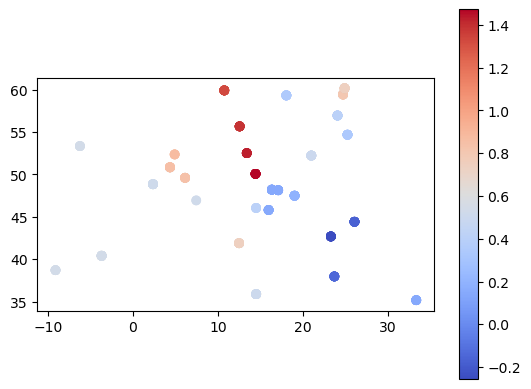

In [30]:
# Visualize results
gdf['GWR_intercept'] = results.params[:, 0]
gdf['GWR_slope'] = results.params[:, 1]

# Plot the map
gdf.plot(column='GWR_slope', cmap='coolwarm', legend=True)

In [31]:
# Load Europe shapefile from an online resource
world = gpd.read_file('world.gpkg')

In [32]:
#world.to_file('world.gpkg', driver='GPKG')
#world.to_file('world.shp', driver='ESRI Shapefile')
world.to_file('world.geojson', driver='GeoJSON')

In [33]:
print(isinstance(world.geometry, str))
print(isinstance(world.geometry, pd.Series))
print(isinstance(world.geometry, gpd.GeoSeries))
print(world.crs)

False
True
True
EPSG:4326


<Axes: >

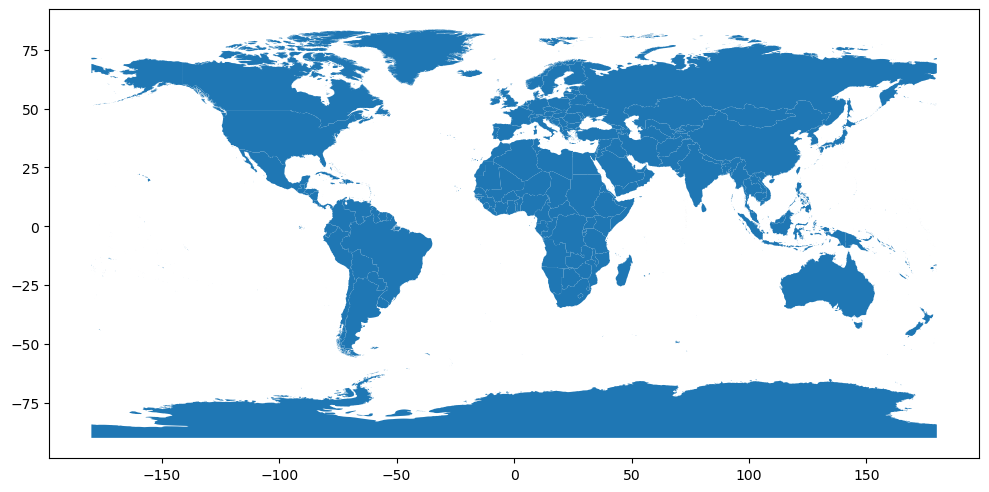

In [34]:
world2 = world.to_crs('epsg:4326')
world2.plot(figsize=(12,8))

In [35]:
# Filter Europe countries from the world shapefile
europe_countries = [
    'AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 
    'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 
    'MLT', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 
    'SWE', 'CHE'
]
europe = world2[world2['ISO3'].isin(europe_countries)]

In [36]:
print(europe.columns)

Index(['FIPS', 'ISO2', 'ISO3', 'UN', 'NAME', 'AREA', 'POP2005', 'REGION',
       'SUBREGION', 'LON', 'LAT', 'geometry'],
      dtype='object')


In [37]:
# Function to plot a map
def plot_map(column, title, cmap='Blues'):
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    europe.boundary.plot(ax=ax, color='black', linewidth=0.8)
    norm = Normalize(vmin=europe[column].min(), vmax=europe[column].max())
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    europe.plot(column=column, cmap=cmap, legend=False, ax=ax, edgecolor='black', linewidth=0.5, norm=norm)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label(column, fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.set_xlim([-25, 45])
    ax.set_ylim([34, 72])
    ax.set_xlabel('Longitude', fontsize=14)
    ax.set_ylabel('Latitude', fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(10))
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()


In [38]:
print(gdf.columns)

Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular',
       'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents',
       'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban',
       'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp',
       'gdp_growth', 'latitude', 'longitude', 'patent', 'DE_index',
       'Innovation_index', 'geometry', 'GWR_intercept', 'GWR_slope'],
      dtype='object')


In [39]:
# Ensure the Europe shapefile has the correct CRS
europe.set_crs(epsg=4326, allow_override=True)

# Merge GWR results with Europe shapefile based on ISO3 codes
gdf = gdf.set_index('ISO3')
europe = europe.set_index('ISO3')



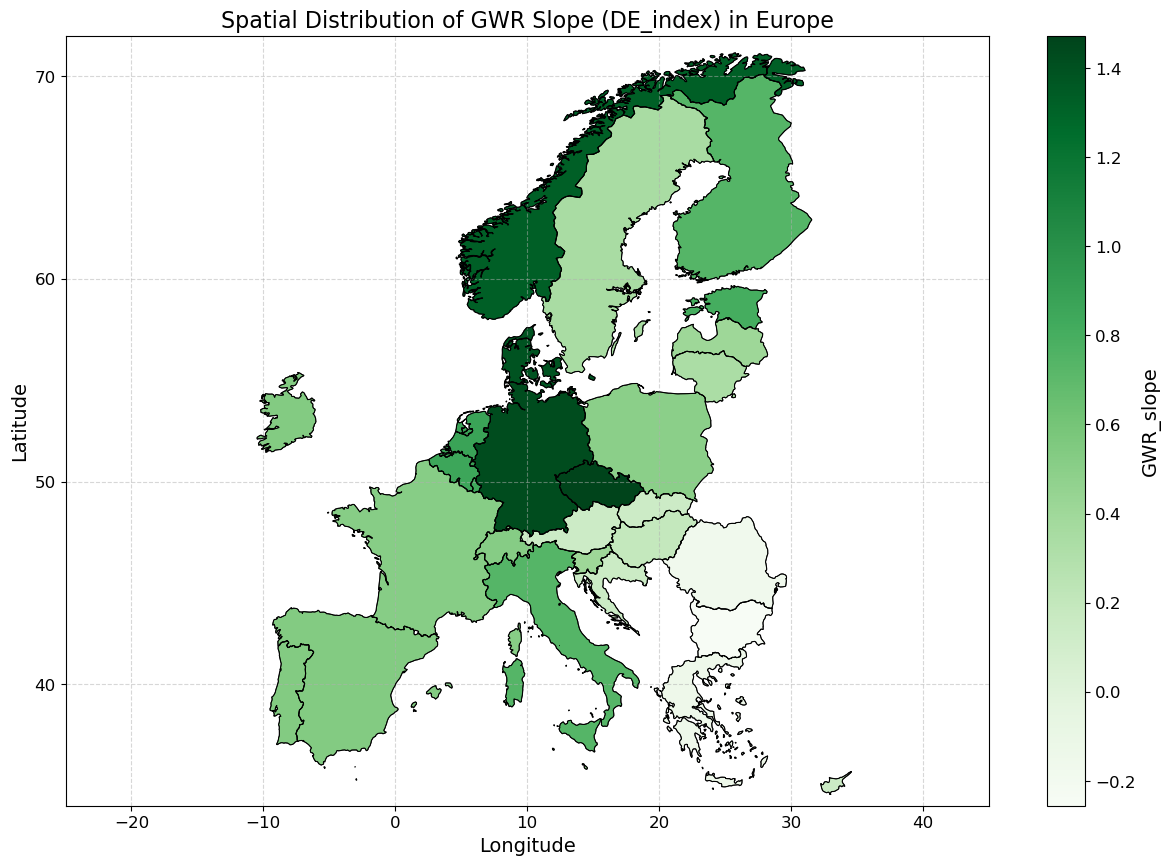

In [40]:
# Add GWR slope to Europe GeoDataFrame
gdf['GWR_slope'] = results.params[:, 1]
average_slope = gdf.groupby('ISO3')['GWR_slope'].mean()
europe['GWR_slope'] = average_slope

# Plot GWR_slope using a detailed color scale
plot_map('GWR_slope', 'Spatial Distribution of GWR Slope (DE_index) in Europe', cmap='Greens')

In [41]:
print(gdf.columns)

Index(['country', 'year', 'broadband', 'telephone', 'cellular', 'internet',
       'credit', 'education', 'ict', 'tech', 'patent_residents',
       'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban',
       'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp',
       'gdp_growth', 'latitude', 'longitude', 'patent', 'DE_index',
       'Innovation_index', 'geometry', 'GWR_intercept', 'GWR_slope'],
      dtype='object')


In [42]:
'''
# Plot the map for the slope (relationship strength)
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
europe.boundary.plot(ax=ax, color='black')
gdf.plot(column='GWR_slope', cmap='coolwarm', legend=True, ax=ax, markersize=50)
ax.set_title('Spatial Distribution of GWR Slope (DE_index) in Europe')
plt.show()
'''

"\n# Plot the map for the slope (relationship strength)\nfig, ax = plt.subplots(1, 1, figsize=(15, 10))\neurope.boundary.plot(ax=ax, color='black')\ngdf.plot(column='GWR_slope', cmap='coolwarm', legend=True, ax=ax, markersize=50)\nax.set_title('Spatial Distribution of GWR Slope (DE_index) in Europe')\nplt.show()\n"

In [43]:
# Ensure all required columns are present
required_columns = ['latitude', 'longitude', 'DE_index', 'Innovation_index', 'ISO3']
missing_columns = [col for col in required_columns if col not in data.columns]
if missing_columns:
    raise KeyError(f"None of {missing_columns} are in the columns")

# Create GeoDataFrame for the input data, ensuring all columns are kept
gdf = gpd.GeoDataFrame(data.copy(), geometry=gpd.points_from_xy(data.longitude, data.latitude))

# Check the columns and head of the GeoDataFrame
print("GeoDataFrame columns:", gdf.columns)
print(gdf.head())

# Ensure the ISO3 column exists in gdf
if 'ISO3' not in gdf.columns:
    raise KeyError("ISO3 column is missing in the GeoDataFrame")

GeoDataFrame columns: Index(['country', 'ISO3', 'year', 'broadband', 'telephone', 'cellular',
       'internet', 'credit', 'education', 'ict', 'tech', 'patent_residents',
       'patent_nonresidents', 'researchers', 'RD', 'gdppc', 'urban',
       'articles', 'business', 'fdi_outflow', 'fdi_inflow', 'gdp',
       'gdp_growth', 'latitude', 'longitude', 'patent', 'DE_index',
       'Innovation_index', 'geometry'],
      dtype='object')
   country ISO3  year  broadband  telephone  cellular  internet    credit  \
0  Austria  AUT  2009   0.048886   0.062718  0.100770  0.595704  0.317835   
1  Austria  AUT  2010   0.053647   0.065709  0.108155  0.623508  0.321264   
2  Austria  AUT  2011   0.054957   0.065502  0.115307  0.681220  0.310539   
3  Austria  AUT  2012   0.055857   0.065338  0.120481  0.702073  0.302552   
4  Austria  AUT  2013   0.058691   0.064389  0.117589  0.711592  0.295310   

   education       ict  ...  fdi_outflow  fdi_inflow           gdp  \
0  67.991577  0.077526  ...   

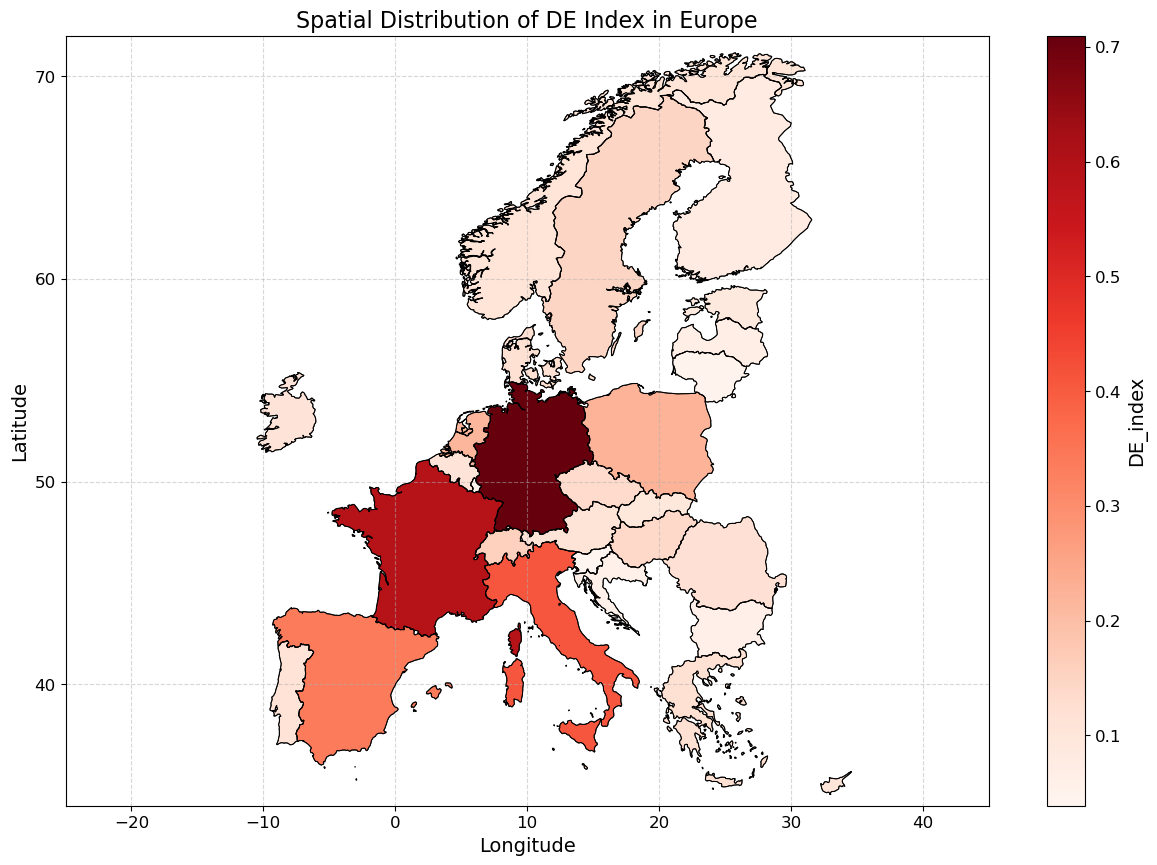

In [44]:
# Calculate the average DE_index for each country
average_de_index = gdf.groupby('ISO3')['DE_index'].mean()
europe['DE_index'] = average_de_index

# Plot DE_index using a detailed color scale
plot_map('DE_index', 'Spatial Distribution of DE Index in Europe', cmap='Reds')

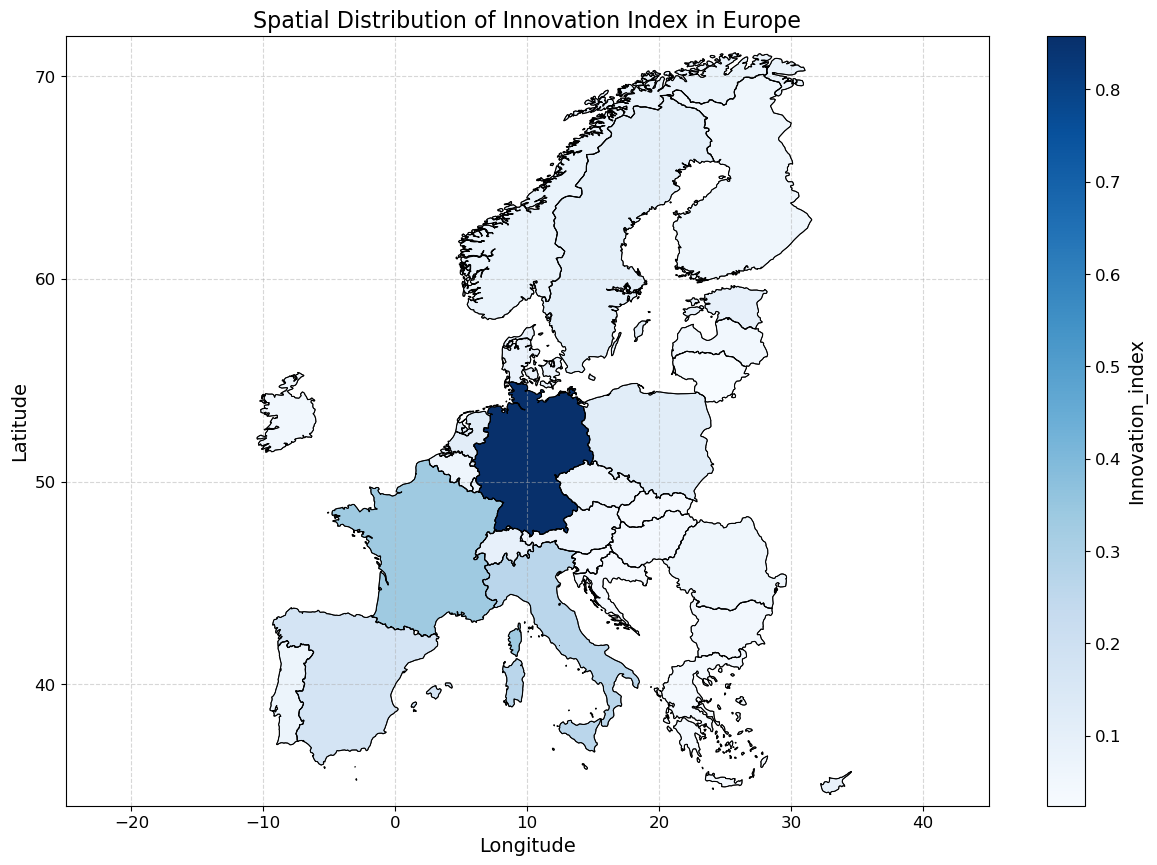

In [45]:
# Calculate the average Innovation_index for each country
average_innovation = gdf.groupby('ISO3')['Innovation_index'].mean()
europe['Innovation_index'] = average_innovation

# Plot Innovation_index
plot_map('Innovation_index', 'Spatial Distribution of Innovation Index in Europe',cmap='Blues')

# 5.Spatial Autocorrelation

## 5.1 Weight matrix

### Geographical Distance Matrix

In [46]:
# Extract the country names and coordinates
countries = data['country']
coordinates = data[['latitude', 'longitude']].values

In [47]:
# Calculate the geographical distance matrix
num_countries = len(countries)
distances = np.zeros((num_countries, num_countries))

for i in range(num_countries):
    for j in range(num_countries):
        if i != j:
            distances[i, j] = geodesic(coordinates[i], coordinates[j]).kilometers
        else:
            distances[i, j] = 0  # Distance to itself is 0

In [48]:
# Add a small value to non-diagonal zero elements to avoid infinite weights
epsilon = 1e-5
distances[distances == 0] = epsilon

# Print the geographical distance matrix
print("Geographical Distance Matrix:")
print(distances)

Geographical Distance Matrix:
[[1.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.24256409e+03
  6.84852340e+02 6.84852340e+02]
 [1.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.24256409e+03
  6.84852340e+02 6.84852340e+02]
 [1.00000000e-05 1.00000000e-05 1.00000000e-05 ... 1.24256409e+03
  6.84852340e+02 6.84852340e+02]
 ...
 [1.24256409e+03 1.24256409e+03 1.24256409e+03 ... 1.00000000e-05
  1.54608161e+03 1.54608161e+03]
 [6.84852340e+02 6.84852340e+02 6.84852340e+02 ... 1.54608161e+03
  1.00000000e-05 1.00000000e-05]
 [6.84852340e+02 6.84852340e+02 6.84852340e+02 ... 1.54608161e+03
  1.00000000e-05 1.00000000e-05]]


In [49]:
# Construct the geographical distance weight matrix (inverse square of distances)
W1 = np.zeros_like(distances)
with np.errstate(divide='ignore', invalid='ignore'):
    W1 = 1 / distances
    W1[distances == 0] = 0  # Set diagonal to 0 to avoid division by zero


In [50]:
# Print the geographical distance weight matrix
print("Geographical Distance Weight Matrix:")
print(W1)

Geographical Distance Weight Matrix:
[[1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 8.04787459e-04
  1.46016877e-03 1.46016877e-03]
 [1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 8.04787459e-04
  1.46016877e-03 1.46016877e-03]
 [1.00000000e+05 1.00000000e+05 1.00000000e+05 ... 8.04787459e-04
  1.46016877e-03 1.46016877e-03]
 ...
 [8.04787459e-04 8.04787459e-04 8.04787459e-04 ... 1.00000000e+05
  6.46796386e-04 6.46796386e-04]
 [1.46016877e-03 1.46016877e-03 1.46016877e-03 ... 6.46796386e-04
  1.00000000e+05 1.00000000e+05]
 [1.46016877e-03 1.46016877e-03 1.46016877e-03 ... 6.46796386e-04
  1.00000000e+05 1.00000000e+05]]


In [51]:
# Save the weight matrix to a CSV file for later use
#np.savetxt('geographical_distance_weight_matrix.csv', W1, delimiter=',')

In [52]:
#distance_matrix.csv', distances, delimiter=',')

### Economic Distance Matrix

In [53]:
# Extract the country names and GDP per capita
countries = data['country']
gdp_per_capita = data['gdppc'].values

# Calculate the economic distance matrix
num_countries = len(countries)
economic_distances = np.zeros((num_countries, num_countries))

for i in range(num_countries):
    for j in range(num_countries):
        if i != j:
            economic_distances[i, j] = abs(gdp_per_capita[i] - gdp_per_capita[j])
        else:
            economic_distances[i, j] = 0  # Distance to itself is 0

# Print the economic distance matrix
print("Economic Distance Matrix:")
print(economic_distances)

Economic Distance Matrix:
[[    0.        679.31683  1795.80806 ...  9297.481   39309.69429
  41151.25547]
 [  679.31683     0.       1116.49123 ...  8618.16417 38630.37746
  40471.93864]
 [ 1795.80806  1116.49123     0.      ...  7501.67294 37513.88623
  39355.44741]
 ...
 [ 9297.481    8618.16417  7501.67294 ...     0.      30012.21329
  31853.77447]
 [39309.69429 38630.37746 37513.88623 ... 30012.21329     0.
   1841.56118]
 [41151.25547 40471.93864 39355.44741 ... 31853.77447  1841.56118
      0.     ]]


In [54]:
# Construct the economic distance weight matrix (inverse of economic distances)
W2 = np.zeros_like(economic_distances)
with np.errstate(divide='ignore', invalid='ignore'):
    W2 = 1 / economic_distances
    W2[economic_distances == 0] = 0  # Set diagonal to 0 to avoid division by zero

# Print the economic distance weight matrix
print("Economic Distance Weight Matrix:")
print(W2)

Economic Distance Weight Matrix:
[[0.00000000e+00 1.47206716e-03 5.56852384e-04 ... 1.07556014e-04
  2.54390175e-05 2.43005952e-05]
 [1.47206716e-03 0.00000000e+00 8.95663103e-04 ... 1.16033993e-04
  2.58863637e-05 2.47084779e-05]
 [5.56852384e-04 8.95663103e-04 0.00000000e+00 ... 1.33303599e-04
  2.66567957e-05 2.54094431e-05]
 ...
 [1.07556014e-04 1.16033993e-04 1.33303599e-04 ... 0.00000000e+00
  3.33197685e-05 3.13934539e-05]
 [2.54390175e-05 2.58863637e-05 2.66567957e-05 ... 3.33197685e-05
  0.00000000e+00 5.43017528e-04]
 [2.43005952e-05 2.47084779e-05 2.54094431e-05 ... 3.13934539e-05
  5.43017528e-04 0.00000000e+00]]


### Economic-Geographical Matrix

In [55]:
W3 = W1 * W2

In [56]:
# Calculate Moran's I using the economic-geographical weight matrix
# Convert the economic-geographical weight matrix to a pysal weights object
w3 = full2W(W3)

moran_DE = Moran(data['DE_index'], w3)

print(f"DE Moran's I: {moran_DE.I}")
print(f"P-value: {moran_DE.p_sim}")

DE Moran's I: 0.9899048462506826
P-value: 0.001


In [57]:
moran_innovation = Moran(data['Innovation_index'], w3)

print(f"Innovation Moran's I: {moran_innovation.I}")
print(f"P-value: {moran_innovation.p_sim}")

Innovation Moran's I: 0.9955311169064024
P-value: 0.001


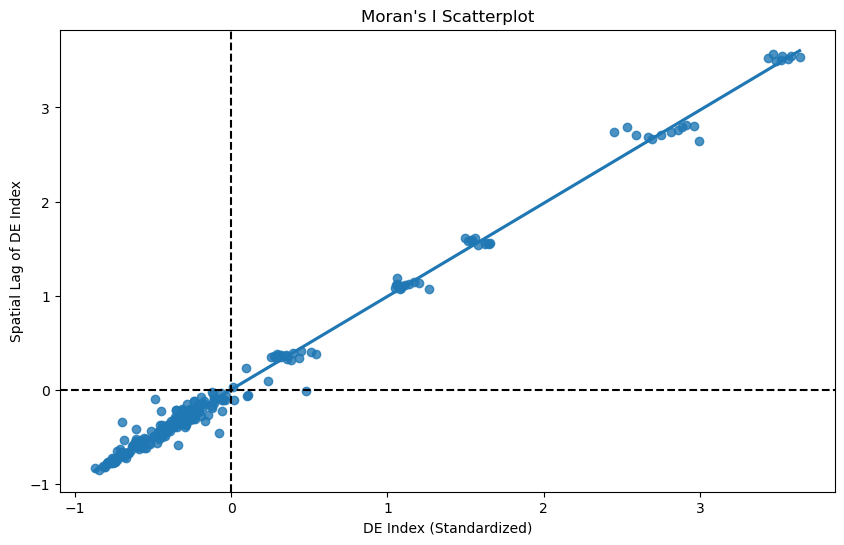

In [58]:
# Manually create the Moran scatter plot
z = (data['DE_index'] - data['DE_index'].mean()) / data['DE_index'].std()
wz = w3.sparse @ z

plt.figure(figsize=(10, 6))
sns.regplot(x=z, y=wz, ci=None)
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')
plt.title("Moran's I Scatterplot")
plt.xlabel("DE Index (Standardized)")
plt.ylabel("Spatial Lag of DE Index")
plt.show()


# 6.Spatial Lag Model (SLM)

## 6.1.Static Spatial Panel Model

In [59]:
# Prepare the variables for the spatial lag model
y = gdf['Innovation_index'].values
X = gdf[['DE_index', 'education', 'RD', 'gdppc', 'urban', 'fdi_inflow']].values

# Add constant term for intercept
X = np.hstack([np.ones((X.shape[0], 1)), X])


# Fit the spatial lag model
model = spreg.ML_Lag(y, X, w=w3, name_y='Innovation_index', name_x=['constant', 'DE_index', 'education', 'RD', 'gdppc', 'urban', 'fdi_inflow'])
print(model.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :Innovation_index                Number of Observations:         290
Mean dependent var  :      0.1103                Number of Variables   :           8
S.D. dependent var  :      0.1451                Degrees of Freedom    :         282
Pseudo R-squared    :      0.9934
Spatial Pseudo R-squared:  0.8137
Sigma-square ML     :       0.000                Log likelihood        :     800.562
S.E of regression   :       0.012                Akaike info criterion :   -1585.123
                                                 Schwarz criterion     :   -1555.764

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------

## 6.2.Dynamic Spatial Panel Model

In [60]:
# Prepare the panel data for the dynamic spatial lag model
gdf.set_index(['country', 'year'], inplace=True)


# Add lagged variables for all predictors
gdf['L.Innovation_index'] = gdf.groupby(level=0)['Innovation_index'].shift(1)
gdf['L.DE_index'] = gdf.groupby(level=0)['DE_index'].shift(1)
gdf['L.education'] = gdf.groupby(level=0)['education'].shift(1)
gdf['L.RD'] = gdf.groupby(level=0)['RD'].shift(1)
gdf['L.gdppc'] = gdf.groupby(level=0)['gdppc'].shift(1)
gdf['L.urban'] = gdf.groupby(level=0)['urban'].shift(1)
gdf['L.fdi_inflow'] = gdf.groupby(level=0)['fdi_inflow'].shift(1)

# Calculate spatially lagged DE_index
gdf['W.DE_index'] = lag_spatial(w3, gdf['DE_index'])

In [61]:
# Drop rows with NaN values created by lagging
gdf.dropna(subset=['L.Innovation_index', 'L.DE_index', 'L.education', 'L.RD', 'L.gdppc', 'L.urban', 'L.fdi_inflow', 'W.DE_index'], inplace=True)

# Ensure y and X have the correct MultiIndex
y = gdf['Innovation_index']
X = gdf[['DE_index', 'L.Innovation_index', 'W.DE_index', 'L.DE_index', 'L.education', 'L.RD', 'L.gdppc', 'L.urban', 'L.fdi_inflow']]

In [62]:
# Fit the dynamic spatial lag model using PanelOLS from linearmodels
model = PanelOLS(y, X, entity_effects=True)
results = model.fit()
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:       Innovation_index   R-squared:                        0.6269
Estimator:                   PanelOLS   R-squared (Between):              0.8065
No. Observations:                 261   R-squared (Within):               0.6269
Date:                Thu, Aug 15 2024   R-squared (Overall):              0.7672
Time:                        09:23:12   Log-likelihood                    945.23
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      41.640
Entities:                          29   P-value                           0.0000
Avg Obs:                       9.0000   Distribution:                   F(9,223)
Min Obs:                       1.0000                                           
Max Obs:                       11.000   F-statistic (robust):             41.640
                            

### The Granger Causality Test

In [63]:
# Granger causality test to check if X Granger-causes Y and vice versa
grangercausalitytests(gdf[['Innovation_index', 'Innovation_index']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=-0.0000 , p=1.0000  , df_denom=258, df_num=1
ssr based chi2 test:   chi2=-0.0000 , p=1.0000  , df=1
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=1
parameter F test:         F=1018.1342, p=0.0000  , df_denom=258, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=256, df_num=2
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=2
likelihood ratio test: chi2=0.0000  , p=1.0000  , df=2
parameter F test:         F=509.0772, p=0.0000  , df_denom=256, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0000  , p=1.0000  , df_denom=254, df_num=3
ssr based chi2 test:   chi2=0.0000  , p=1.0000  , df=3
likelihood ratio test: chi2=-0.0000 , p=1.0000  , df=3
parameter F test:         F=337.9891, p=0.0000  , df_denom=254, df_num=3


{1: ({'ssr_ftest': (-1.0459597960346975e-13, 1.0, 258.0, 1),
   'ssr_chi2test': (-1.0540680115078346e-13, 1.0, 1),
   'lrtest': (-0.0, 1.0, 1),
   'params_ftest': (1018.1342138889248, 1.522808795657085e-91, 258.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (2.6124835658619456e-14, 0.9999999999999716, 256.0, 2),
   'ssr_chi2test': (5.28619721529878e-14, 0.9999999999999736, 2),
   'lrtest': (2.2737367544323206e-13, 0.9999999999998863, 2),
   'params_ftest': (509.0771692644208, 6.113568451650131e-90, 256.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.0, 1.0, 254.0, 3),
   'ssr_chi2test': (0.0, 1.0, 3),
   'lrtest': (-0.0, 1.0, 3),
   'params_ftest': (337.989111847708, 2.3805422386388418e-88, 254.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 1., 0.]])])}

In [64]:
grangercausalitytests(gdf[['DE_index', 'Innovation_index']], maxlag=3)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7791  , p=0.0967  , df_denom=257, df_num=1
ssr based chi2 test:   chi2=2.8115  , p=0.0936  , df=1
likelihood ratio test: chi2=2.7964  , p=0.0945  , df=1
parameter F test:         F=2.7791  , p=0.0967  , df_denom=257, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9269  , p=0.1477  , df_denom=254, df_num=2
ssr based chi2 test:   chi2=3.9298  , p=0.1402  , df=2
likelihood ratio test: chi2=3.9002  , p=0.1423  , df=2
parameter F test:         F=1.9269  , p=0.1477  , df_denom=254, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3557  , p=0.2569  , df_denom=251, df_num=3
ssr based chi2 test:   chi2=4.1804  , p=0.2426  , df=3
likelihood ratio test: chi2=4.1469  , p=0.2460  , df=3
parameter F test:         F=1.3557  , p=0.2569  , df_denom=251, df_num=3


{1: ({'ssr_ftest': (2.779088433384741, 0.09672062658476382, 257.0, 1),
   'ssr_chi2test': (2.8115291543970145, 0.09358912752487711, 1),
   'lrtest': (2.7964365216237184, 0.09447406465407047, 1),
   'params_ftest': (2.779088433384703, 0.0967206265847678, 257.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.9269450308465803, 0.14771468548642366, 254.0, 2),
   'ssr_chi2test': (3.929754039285546, 0.1401731240967329, 2),
   'lrtest': (3.9002395326417627, 0.14225703296474976, 2),
   'params_ftest': (1.926945030846561, 0.14771468548642644, 254.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.3556525172746055, 0.2569247932618953, 251.0, 3),
   'ssr_chi2test': (4.180378678767109, 0.24263370805774895, 3),
   'lrtest': (4.146872749925478, 0.24603504830988396, 3),
   'params_ftest': (1.3556525172745975, 0.2569247932618953, 251.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.

In [65]:
for var in ['DE_index', 'education', 'RD', 'gdppc', 'urban', 'fdi_inflow']:  
    print(f"Testing Granger causality between {var} and Y")
    grangercausalitytests(gdf[[var, 'Innovation_index']], maxlag=3)

Testing Granger causality between DE_index and Y

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7791  , p=0.0967  , df_denom=257, df_num=1
ssr based chi2 test:   chi2=2.8115  , p=0.0936  , df=1
likelihood ratio test: chi2=2.7964  , p=0.0945  , df=1
parameter F test:         F=2.7791  , p=0.0967  , df_denom=257, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9269  , p=0.1477  , df_denom=254, df_num=2
ssr based chi2 test:   chi2=3.9298  , p=0.1402  , df=2
likelihood ratio test: chi2=3.9002  , p=0.1423  , df=2
parameter F test:         F=1.9269  , p=0.1477  , df_denom=254, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3557  , p=0.2569  , df_denom=251, df_num=3
ssr based chi2 test:   chi2=4.1804  , p=0.2426  , df=3
likelihood ratio test: chi2=4.1469  , p=0.2460  , df=3
parameter F test:         F=1.3557  , p=0.2569  , df_denom=251, df_num=3
Testing Granger causality between education a